

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/CLASSIFICATION_De_SENTIMENT.ipynb)






# **Sentiment Analysis of German texts**

## 1. Colab Setup

In [ ]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.3.0 spark-nlp==4.2.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 20.4 MB/s eta 0:00:00


In [ ]:
!pip install pandas openpyxl

In [ ]:
import json
import pandas as pd
import numpy as np

import sparknlp
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType

## 2. Start Spark Session

In [ ]:
spark = sparknlp.start()
print ("Spark NLP Version :", sparknlp.version())
spark

Spark NLP Version : 4.2.8


## 3. Data Preprocessing

In [ ]:
import pandas as pd
input_file = 'Eberswaldeneu.xlsx'

# Read all sheet from Excel file
xls = pd.ExcelFile(input_file)

# Loop through each sheet and save as a new Excel file
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    output_file = f'{sheet_name}.xlsx'
    df.to_excel(output_file, index=False)
    print(f'Sheet "{sheet_name}" saved as {output_file}')

Sheet "Sheet1" saved as Sheet1.xlsx


In [ ]:
import pandas as pd

# Define file name
input_file = 'Sheet1.xlsx'
output_file = 'Eberswaldeneu.xlsx'

# Read Excel file
df = pd.read_excel(input_file)

# Iterate through the rows of the dataframe
for i in range(1, len(df)):
    # If column A in row i is empty, join column B with the previous row
    if pd.isna(df.iloc[i, 0]):
        df.iloc[i-1, 1] = str(df.iloc[i-1, 1]) + ' ' + str(df.iloc[i, 1])

# Delete rows where column A is empty
df = df[df.iloc[:, 0].notna()]

# Save the cleaned dataframe to a new Excel file
df.to_excel(output_file, index=False)

print(f'Saved as {output_file}')

In [ ]:
import pandas as pd

# Load the data from the provided Excel file
file_path = 'Eberswaldeneu.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Yvonne,Dashti (10/20 - 09/19)
0,1,"Ich bin noch nicht lange da, aber sehr zufried..."
1,2,"Eine sehr kompetente, emphatische Ärztin die s..."
2,Hiwa,Dashti (11/19 - 12/15)
3,1,Bin von einer gräßlichen Diabetologin zu ihm g...
4,2,Ich war während der Akutsprechstunde wegen des...


In [ ]:
import re

# Preprocess the data
def preprocess_data(df):
    doctors = []
    reviews = []
    current_doctor = None

    for index, row in df.iterrows():
        if re.match(r'^[a-zA-Z]', str(row[0])):  # If the row starts with letters, it is a doctor's name
            current_doctor = row[0]
        else:
            reviews.append(row[1])
            doctors.append(current_doctor)

    return pd.DataFrame({'Doctor': doctors, 'Review': reviews})

# Apply preprocessing
processed_data = preprocess_data(data)

# Display the first few rows of the processed dataframe
processed_data.head()

<ipython-input-26-d1d0d0e30fbd>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if re.match(r'^[a-zA-Z]', str(row[0])):  # If the row starts with letters, it is a doctor's name
<ipython-input-26-d1d0d0e30fbd>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reviews.append(row[1])
<ipython-input-26-d1d0d0e30fbd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_doctor = row[0]


,Doctor,Review
0,None,"Ich bin noch nicht lange da, aber sehr zufried..."
1,None,"Eine sehr kompetente, emphatische Ärztin die s..."
2,Hiwa,Bin von einer gräßlichen Diabetologin zu ihm g...
3,Hiwa,Ich war während der Akutsprechstunde wegen des...
4,Hiwa,"Herr Dr. Dashti nimmt sich ausreichend Zeit, h..."


In [ ]:
processed_data

,Doctor,Review
0,None,"Ich bin noch nicht lange da, aber sehr zufried..."
1,None,"Eine sehr kompetente, emphatische Ärztin die s..."
2,Hiwa,Bin von einer gräßlichen Diabetologin zu ihm g...
3,Hiwa,Ich war während der Akutsprechstunde wegen des...
4,Hiwa,"Herr Dr. Dashti nimmt sich ausreichend Zeit, h..."
...,...,...
240,Ulrike,"Nicht nur die Ärztin, sondern auch das gesamte..."
241,Ulrike,der Bewertung vom11.12.2013 kann ich nur zusti...
242,Ulrike,Man wird sehr gut beraten. Sie hat ein sehr gu...
243,Henry,"Optimale Versorgung, immer freundlich ebenso d..."


In [ ]:
# Function to preprocess data by filling NaN/None values with the previous value
def preprocess_data(df):
    df['Doctor'] = df['Doctor'].fillna(method='ffill')
    return df

# Apply preprocessing
processed_data = preprocess_data(processed_data)

# Display the first few rows of the processed dataframe to verify the changes
processed_data.head()

<ipython-input-28-64cad24f991f>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Doctor'] = df['Doctor'].fillna(method='ffill')


,Doctor,Review
0,None,"Ich bin noch nicht lange da, aber sehr zufried..."
1,None,"Eine sehr kompetente, emphatische Ärztin die s..."
2,Hiwa,Bin von einer gräßlichen Diabetologin zu ihm g...
3,Hiwa,Ich war während der Akutsprechstunde wegen des...
4,Hiwa,"Herr Dr. Dashti nimmt sich ausreichend Zeit, h..."


In [ ]:
# Fill empty column
processed_data['Doctor'] = processed_data['Doctor'].replace({None: 'Yvonne'})

print(processed_data)

      Doctor                                             Review
0     Yvonne  Ich bin noch nicht lange da, aber sehr zufried...
1     Yvonne  Eine sehr kompetente, emphatische Ärztin die s...
2       Hiwa  Bin von einer gräßlichen Diabetologin zu ihm g...
3       Hiwa  Ich war während der Akutsprechstunde wegen des...
4       Hiwa  Herr Dr. Dashti nimmt sich ausreichend Zeit, h...
..       ...                                                ...
240  Ulrike   Nicht nur die Ärztin, sondern auch das gesamte...
241  Ulrike   der Bewertung vom11.12.2013 kann ich nur zusti...
242  Ulrike   Man wird sehr gut beraten. Sie hat ein sehr gu...
243    Henry  Optimale Versorgung, immer freundlich ebenso d...
244    Henry  Betreuung durch die Schwestern ist verbesserun...

[245 rows x 2 columns]


In [ ]:
# Clean the data by removing entries with None or NaN in the Doctor column
cleaned_data1 = processed_data.dropna(subset=['Doctor'])

# Verify the cleaning process
cleaned_data1

,Doctor,Review
0,Yvonne,"Ich bin noch nicht lange da, aber sehr zufried..."
1,Yvonne,"Eine sehr kompetente, emphatische Ärztin die s..."
2,Hiwa,Bin von einer gräßlichen Diabetologin zu ihm g...
3,Hiwa,Ich war während der Akutsprechstunde wegen des...
4,Hiwa,"Herr Dr. Dashti nimmt sich ausreichend Zeit, h..."
...,...,...
240,Ulrike,"Nicht nur die Ärztin, sondern auch das gesamte..."
241,Ulrike,der Bewertung vom11.12.2013 kann ich nur zusti...
242,Ulrike,Man wird sehr gut beraten. Sie hat ein sehr gu...
243,Henry,"Optimale Versorgung, immer freundlich ebenso d..."


In [ ]:
cleaned_data1.to_excel('outputES.xlsx', index=False)

In [ ]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('outputES.xlsx')  # Replace with your actual file path

# Convert the specific column to a list
text_list = df['Review'].tolist()

# Format the list to the desired structure
formatted_list = [f'"""{text}"""' for text in text_list]

# Join with commas and newlines to get the final string
final_string = ",\n".join(formatted_list)

# Print or use the final string
print(f"text_list = [\n{final_string}\n]")

## 4. Define Spark NLP pipeline

In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

embeddings = BertSentenceEmbeddings\
    .pretrained('labse', 'xx') \
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

sentimentClassifier = ClassifierDLModel.pretrained("classifierdl_bert_sentiment", "de") \
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("class_")

nlpPipeline = Pipeline(
    stages=[
      document,
      embeddings,
      sentimentClassifier
      ])

labse download started this may take some time.
Approximate size to download 1.7 GB
[OK!]
classifierdl_bert_sentiment download started this may take some time.
Approximate size to download 22.2 MB
[OK!]


## 5. Run the pipeline

In [ ]:
df = spark.createDataFrame(text_list, StringType()).toDF("text")
result = nlpPipeline.fit(df).transform(df)

## 6. Visualize results

In [ ]:
result.select(F.explode(F.arrays_zip(result.document.result,
                                     result.class_.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("document"),
              F.expr("cols['1']").alias("class")).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd

# 'result' is the final Spark DataFrame after NLP processing

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = result.select(F.explode(F.arrays_zip(result.document.result,
                                                 result.class_.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("Review"),
                          F.expr("cols['1']").alias("Sentiment")) \
                  .toPandas()



In [ ]:
# Write the Pandas DataFrame to an Excel file
pandas_df.to_excel('EberswaldeneuBest.xlsx', index=False)  # Replace 'output.xlsx' with your desired file name

print("Data has been successfully written to Excel.")

Data has been successfully written to Excel.


In [ ]:
pandas_df

,Review,Sentiment
0,"Ich bin noch nicht lange da, aber sehr zufried...",POSITIVE
1,"Eine sehr kompetente, emphatische Ärztin die s...",POSITIVE
2,Bin von einer gräßlichen Diabetologin zu ihm g...,POSITIVE
3,Ich war während der Akutsprechstunde wegen des...,POSITIVE
4,"Herr Dr. Dashti nimmt sich ausreichend Zeit, h...",POSITIVE
...,...,...
240,"Nicht nur die Ärztin, sondern auch das gesamte...",POSITIVE
241,der Bewertung vom11.12.2013 kann ich nur zusti...,POSITIVE
242,Man wird sehr gut beraten. Sie hat ein sehr gu...,POSITIVE
243,"Optimale Versorgung, immer freundlich ebenso d...",POSITIVE


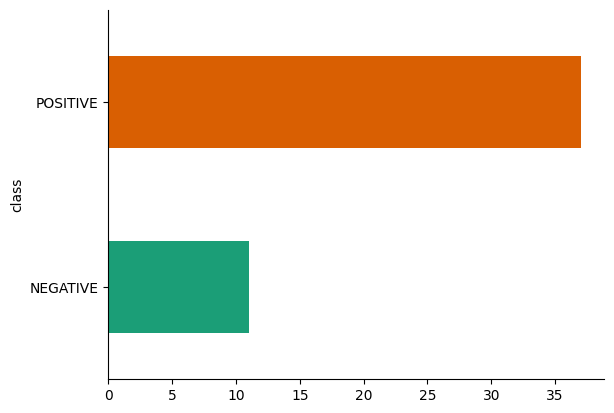

In [ ]:
# @title class

from matplotlib import pyplot as plt
import seaborn as sns
pandas_df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# Initialisation of tokenizer and model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to get sentiment score
def get_polarity(review):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits[0].numpy()
    scores = softmax(scores)

    # Sentiment score: from very negative to very positive
    sentiment_score = (-2 * scores[0] - scores[1] + scores[3] + 2 * scores[4])
    sentiment_score = sentiment_score / 2
    return sentiment_score

# Adding polarity column to DataFrame
pandas_df['OldPolarity'] = pandas_df['Review'].apply(get_polarity)

# Display the DataFrame with the new polarity column
print(pandas_df)

                                                Review Sentiment  OldPolarity
0    Ich bin noch nicht lange da, aber sehr zufried...  POSITIVE     1.470929
1    Eine sehr kompetente, emphatische Ärztin die s...  POSITIVE     1.875710
2    Bin von einer gräßlichen Diabetologin zu ihm g...  POSITIVE     1.902178
3    Ich war während der Akutsprechstunde wegen des...  POSITIVE     0.912071
4    Herr Dr. Dashti nimmt sich ausreichend Zeit, h...  POSITIVE     1.725250
..                                                 ...       ...          ...
240  Nicht nur die Ärztin, sondern auch das gesamte...  POSITIVE     1.621708
241  der Bewertung vom11.12.2013 kann ich nur zusti...  POSITIVE     0.821711
242  Man wird sehr gut beraten. Sie hat ein sehr gu...  POSITIVE     1.686646
243  Optimale Versorgung, immer freundlich ebenso d...  POSITIVE     1.944321
244  Betreuung durch die Schwestern ist verbesserun...  NEGATIVE    -0.220176

[245 rows x 3 columns]


In [ ]:
pandas_df['Polarity'] = pandas_df['OldPolarity'].apply(apply_formula)

In [ ]:
pandas_df.head()

,Review,Sentiment,OldPolarity,Polarity
0,"Ich bin noch nicht lange da, aber sehr zufried...",POSITIVE,1.470929,0.470929
1,"Eine sehr kompetente, emphatische Ärztin die s...",POSITIVE,1.875710,0.875710
2,Bin von einer gräßlichen Diabetologin zu ihm g...,POSITIVE,1.902178,0.902178
3,Ich war während der Akutsprechstunde wegen des...,POSITIVE,0.912071,0.912071
4,"Herr Dr. Dashti nimmt sich ausreichend Zeit, h...",POSITIVE,1.725250,0.725250


In [ ]:
pandas_df.to_excel('EberswaldeneuLast.xlsx', index=False)